In [61]:
import os
import cv2
from keras import backend as K
#from keras.preprocessing import image
import keras.utils as image
from keras.applications import imagenet_utils
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

print("NumPy version: {}".format(np.__version__))
print("OPenCV version: {}".format(cv2.__version__))

NumPy version: 1.22.4
OPenCV version: 4.7.0


In [62]:
def processing_image(img_path):
    print("  ")
    print("------------------------")
    print("processing_image")
    
    # 讀取影像為 PIL 影像
    img = image.load_img(img_path, target_size=(224, 224))
    #print(img.shape)
    
    # 轉換 PIL 影像為 nparray
    x = image.img_to_array(img)
    print("(1) x.shape = ",x.shape) #(224,224,3)

    # 加上一個 batch size，例如轉換 (224, 224, 3) 為 （1, 224, 224, 3) 
    x = np.expand_dims(x, axis=0)
    print("(2) x.shape = ",x.shape) #(1, 224, 224, 3)
    
    # 將 RGB 轉換為 BGR，並解減去各通道平均
    x = preprocess_input(x)
    print("(3) x.shape = ",x.shape) #(1, 224, 224, 3)
        
    return x

In [83]:
def gradcam(model, x):
    
    print("  ")
    print("------------------------")
    print("gradcam")
    print("(4) x.shape = ",x.shape) #(1, 224, 224, 3)
       
    index = 0 
    # 0:bull_mastiff, 1:boxer, 2:tiger_cat, 3:Border_terrier, 4:Airedale 
    
    # 取得影像的分類類別
    preds = model.predict(x)
    print("(5) preds.shape = ",preds.shape) #(1, 1000)
    L = np.argsort(-preds,axis=1)
    print(L[0][0],L[0][1],L[0][2],L[0][3],L[0][4])
    pred_class = L[0][index]
    print("(6) pred_class = ",pred_class) #243
        
    pred_class_list = imagenet_utils.decode_predictions(preds)
    print("(7) pred_class_list = ",pred_class_list)
    
    # 取得影像分類名稱
    pred_class_name = pred_class_list[0][index][1]
    print("(8) pred_class_name = ",pred_class_name) #name
    
    
    with tf.GradientTape() as tape:
      # 最後一層 convolution layer 輸出的 feature map
      # ResNet 的最後一層 convolution layer
      last_conv_layer = model.get_layer('conv5_block3_3_conv')
      print("(11) last_conv_layer = ",last_conv_layer) #Keras layer
      # last_conv_layer = model.get_layer(the_layer)
      tape.watch(last_conv_layer.output)
      # 預測分類的輸出向量
      pred_output = model.output[:, pred_class]
      print("(9) pred_output.shape = ",pred_output.shape) #(?,)
      print("(10) pred_output = ",pred_output) #Tensor
    
      
    # 求得分類的神經元對於最後一層 convolution layer 的梯度
    grads = K.gradients(pred_output, last_conv_layer.output)[0]
      
      #grads=tape.gradient(pred_output, last_conv_layer.output)
    print(grads)
    print("(12) grads.shape = ",grads.shape) #(?, 7, 7, 2048)
    
    # 求得針對每個 feature map 的梯度加總
    pooled_grads = K.sum(grads, axis=(0, 1, 2))
    print("(13) pooled_grads.shape = ",pooled_grads.shape) #(2048,)
    
    
    # K.function() 讓我們可以藉由輸入影像至 `model.input` 得到 `pooled_grads` 與
    # `last_conv_layer[0]` 的輸出值，像似在 Tensorflow 中定義計算圖後使用 feed_dict
    # 的方式。
    Afeature = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    print("(14) last_conv_layer.output[0].shape = ",last_conv_layer.output[0].shape) #(7, 7, 2048)
        
    
    # 傳入影像矩陣 x，並得到分類對 feature map 的梯度與最後一層 convolution layer 的 
    # feature map
    pooled_grads_value, conv_layer_output_value = Afeature([x])
    print("(15) pooled_grads_value.shape = ",pooled_grads_value.shape) #(2048,) 
    print("(16) conv_layer_output_value.shape = ",conv_layer_output_value.shape) #(7, 7, 2048)
    
    # 將 feature map 乘以權重，等於該 feature map 中的某些區域對於該分類的重要性
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])
    
    # 計算 feature map 的 channel-wise 加總
    heatmap = np.sum(conv_layer_output_value, axis=-1)
    print("(17) heatmap.shape = ",heatmap.shape) #(7, 7)
    
    return heatmap, pred_class_name

In [64]:
def plot_heatmap(heatmap, img_path, pred_class_name):
    print("  ")
    print("------------------------")
    print("plot_heatmap")
    
    # ReLU
    heatmap = np.maximum(heatmap, 0)
    
    # 正規化
    heatmap /= np.max(heatmap)
    
    # 讀取影像
    img = cv2.imread(img_path)
    
    fig, ax = plt.subplots()
    
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (img.shape[1], img.shape[0]))

    # 拉伸 heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    
    # 以 0.6 透明度繪製原始影像
    ax.imshow(im, alpha=0.6)
    
    # 以 0.4 透明度繪製熱力圖
    ax.imshow(heatmap, cmap='jet', alpha=0.4)
    
    plt.title(pred_class_name)
    
    plt.show()

In [65]:
model = ResNet50(weights='imagenet')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [77]:
!wget "https://media-proc-wowm.bastillepost.com/wp-content/uploads/hongkong/2019/08/190812_EN_%E9%99%B3%E6%9B%89%E8%8F%AF1.jpg"
#!wget "https://img.ltn.com.tw/Upload/ent/page/800/2019/03/03/phpINsHdf.jpg"

--2023-05-07 02:53:46--  https://media-proc-wowm.bastillepost.com/wp-content/uploads/hongkong/2019/08/190812_EN_%E9%99%B3%E6%9B%89%E8%8F%AF1.jpg
Resolving media-proc-wowm.bastillepost.com (media-proc-wowm.bastillepost.com)... 172.67.10.11, 104.22.53.207, 104.22.52.207, ...
Connecting to media-proc-wowm.bastillepost.com (media-proc-wowm.bastillepost.com)|172.67.10.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/png]
Saving to: ‘190812_EN_陳曉華1.jpg.4’

190812_EN_陳曉華1.j     [ <=>                ] 319.05K  --.-KB/s    in 0.02s   

2023-05-07 02:53:46 (14.7 MB/s) - ‘190812_EN_陳曉華1.jpg.4’ saved [326709]



  
------------------------
processing_image
(1) x.shape =  (224, 224, 3)
(2) x.shape =  (1, 224, 224, 3)
(3) x.shape =  (1, 224, 224, 3)
  
------------------------
gradcam
(4) x.shape =  (1, 224, 224, 3)
(5) preds.shape =  (1, 1000)
445 459 638 639 655
(6) pred_class =  445
(7) pred_class_list =  [[('n02837789', 'bikini', 0.7971159), ('n02892767', 'brassiere', 0.15568501), ('n03710637', 'maillot', 0.037752993), ('n03710721', 'maillot', 0.0021826066), ('n03770439', 'miniskirt', 0.0014650854)]]
(8) pred_class_name =  bikini
(11) last_conv_layer =  <keras.layers.convolutional.conv2d.Conv2D object at 0x7fa03e1438b0>
(9) pred_output.shape =  (None,)
(10) pred_output =  Tensor("strided_slice_23:0", shape=(None,), dtype=float32)
Tensor("gradients_4/conv5_block3_3_bn_2/cond_grad/Identity_4:0", shape=(None, 7, 7, 2048), dtype=float32)
(12) grads.shape =  (None, 7, 7, 2048)
(13) pooled_grads.shape =  (2048,)
(14) last_conv_layer.output[0].shape =  (7, 7, 2048)
(15) pooled_grads_value.shape =  

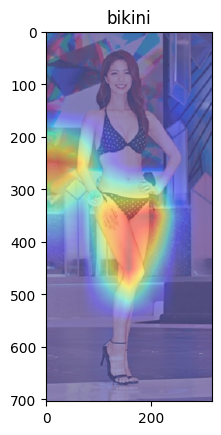

In [84]:
img_path = '190812_EN_陳曉華1.jpg'
#img_path = 'phpINsHdf.jpg'
img = processing_image(img_path)
target_layer = 'conv5_block3_3_conv'
heatmap, pred_class_name = gradcam(model, img)
plot_heatmap(heatmap, img_path, pred_class_name)